## Importing the Libraries

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

## Loading the Data

Defining a function to load the data in sorted order

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from os import listdir
import cv2
import numpy as np
from matplotlib import pyplot as plt

framObj = {'img': [], 'mask': []}

# defining data Loader function
def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=256):
    imgNames = listdir(imgPath)
    maskNames = listdir(maskPath)

    images = []
    masks = []

    for i in range(len(imgNames)):
      images.append(imgNames[i] )
    for m in range(len(maskNames)):
      masks.append(maskNames[m] )

    images.sort()
    masks.sort()

    for i in range(10):
      print("Image : ",images[i])
      print("Masks : ",masks[i])

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range(len(images)):
        img = plt.imread(imgAddr + images[i])
        mask = plt.imread(maskAddr + masks[i])

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        '''

        img = np.clip(img - np.median(img)+127, 0, 255)
        img = img/255.0
        img = img.astype(np.float32)


        mask = mask.astype(np.float32)
        mask = mask/255.0
        '''

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

In [ ]:
framObj = LoadData(framObj,
                        imgPath='/content/drive/MyDrive/dataset/images' ,
                        maskPath='/content/drive/MyDrive/dataset/masks',
                        shape=256)

Image :  image (1).png
Masks :  mask (1).png
Image :  image (10).png
Masks :  mask (10).png
Image :  image (100).png
Masks :  mask (100).png
Image :  image (101).png
Masks :  mask (101).png
Image :  image (102).png
Masks :  mask (102).png
Image :  image (103).png
Masks :  mask (103).png
Image :  image (104).png
Masks :  mask (104).png
Image :  image (105).png
Masks :  mask (105).png
Image :  image (106).png
Masks :  mask (106).png
Image :  image (107).png
Masks :  mask (107).png


Splitting the dataset into training set and test set to verify our model performance without any bias.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(framObj['img'], framObj['mask'], test_size = 0.10, random_state = 101)

In [ ]:
print(np.shape(x_train))
print(np.shape(y_train))

In [ ]:
print(np.shape(x_test))
print(np.shape(y_test))

Let's plot an image to see how the original images look.

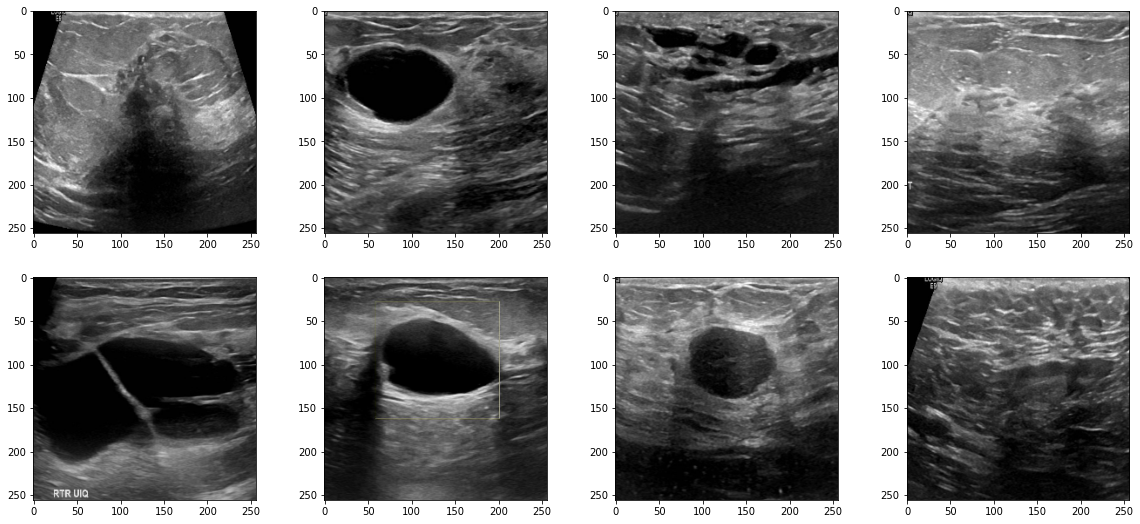

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(x_train[10])
plt.subplot(2,4,2)
plt.imshow(x_train[20])
plt.subplot(2,4,3)
plt.imshow(x_train[30])
plt.subplot(2,4,4)
plt.imshow(x_train[40])
plt.subplot(2,4,5)
plt.imshow(x_train[50])
plt.subplot(2,4,6)
plt.imshow(x_train[60])
plt.subplot(2,4,7)
plt.imshow(x_train[70])
plt.subplot(2,4,8)
plt.imshow(x_train[80])
plt.show()


Now let's see their corresponding masks.

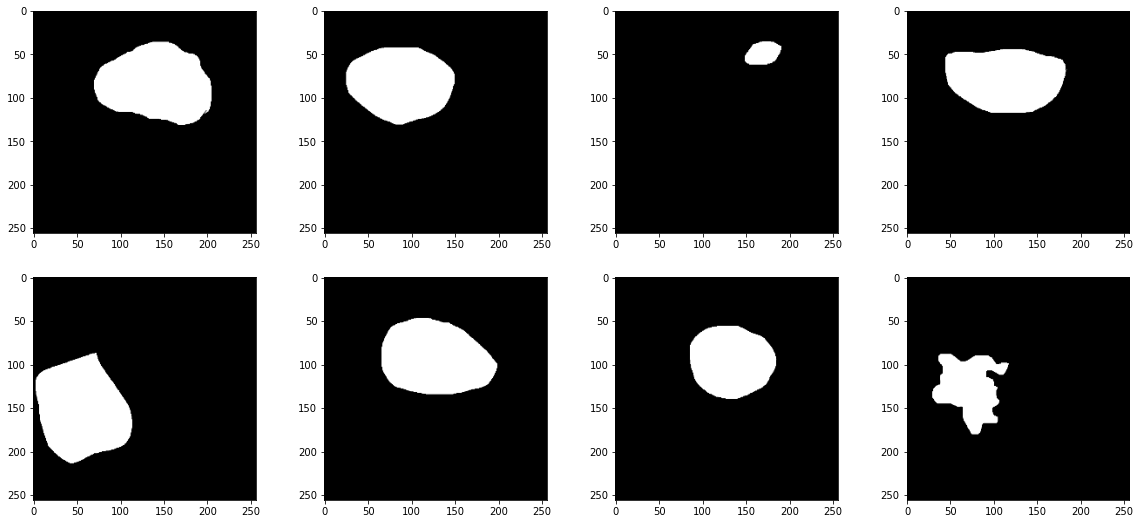

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(y_train[10], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(y_train[20], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(y_train[30], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(y_train[40], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(y_train[50], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(y_train[60], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(y_train[70], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(y_train[80], cmap = plt.cm.binary_r)
plt.show()

## Defining Evaluation Metrics

#### Intersection over Union  
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

![iou](https://www.d2l.ai/_images/iou.svg)

In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#### Dice coefficient
The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. so it is more similar to precision than accuracy.

![dc](https://cdn-images-1.medium.com/max/1600/1*Z1hkDvyhFBogT9EkzVkX2A.png)

In [ ]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

#### Precision    
Precision is a good measure to determine, when the costs of False Positive is high.

![precsion](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

In [ ]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#### Recall  
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


![recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

In [ ]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#### Accuracy

In [ ]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

## Image Augmentation  
To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

We are going to define to methods for augmentation, one for **random rotation** and one for **horizontal flipping**

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [ ]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)

        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)

        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

calling the functions for the training data.

In [ ]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

Let us have a look at our transformations.

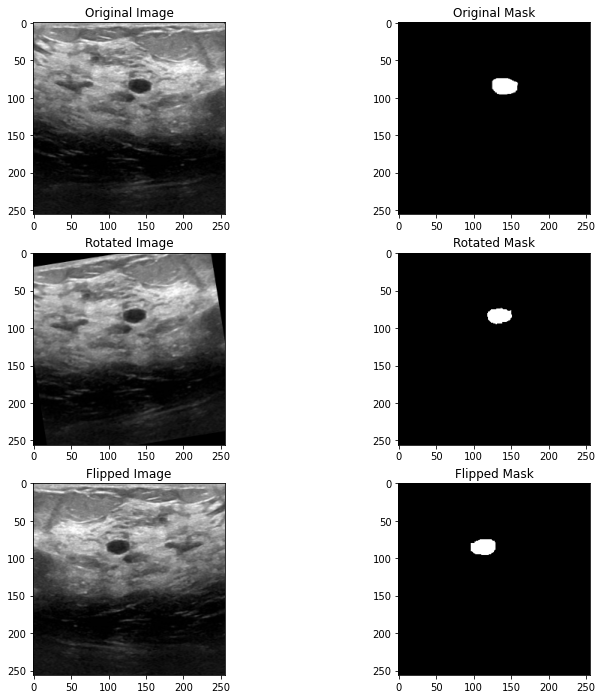

In [ ]:
img_num = 100
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

Now we join all the augmentations image arrays to the original training arrays.

In [ ]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [ ]:
# For test Set
x_test_full = np.concatenate([x_test, x_rotated_t, x_flipped_t])
y_test_full = np.concatenate([y_test, y_rotated_t, y_flipped_t])

#### Making a Validation Set
We will split our full training set into train and validation set.  
Validation dataset is used to validate the performance after each epoch.

In [ ]:
x_train, x_val , y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [ ]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 1396
Length of the Test Set       : 65
Length of the Validation Set : 350


In [ ]:
print("Length of the Training Set   : {}".format(np.shape(x_train)))
print("Length of the Test Set       : {}".format(np.shape(x_test)))
print("Length of the Validation Set : {}".format(np.shape(x_val)))

Length of the Training Set   : (1396, 256, 256, 3)
Length of the Test Set       : (65, 256, 256, 3)
Length of the Validation Set : (350, 256, 256, 3)


## Architecture of the proposed Method

Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

In [ ]:
def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def encoder(inputs):
    skip_connections = []

    model = EfficientNetB7(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["input_2", "block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5a_expand_activation").output
    return output, skip_connections

In [ ]:
def decoder(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

In [ ]:
def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

In [ ]:
def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

In [ ]:
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [ ]:
def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder(inputs)
    x = ASPP(x, 64)
    x = decoder(x, skip_1)
    outputs = output_block(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
model = build_model((256, 256, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

In [ ]:
model.compile(optimizer= Adam(learning_rate=1e-4), loss= dice_loss
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
#model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
mc = ModelCheckpoint('best_model_model.h5',
                     monitor='val_accuracy',
                     mode='max', verbose=1,
                     save_best_only=True)

In [ ]:
import datetime
now = datetime.datetime.now
t = now()
hist = model.fit(x_train, y_train, epochs= 100, batch_size= 18,callbacks=[mc,es], validation_data= (x_val, y_val), verbose=1)

print('Training time: %s' % (now() - t))

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.7121 - iou: 0.6966 - dice_coef: 0.2884 - precision: 0.2235 - recall: 0.8709 - accuracy: 0.6729
Epoch 00001: val_accuracy improved from -inf to 0.09222, saving model to best_model_model.h5
78/78 [==============================] - 95s 943ms/step - loss: 0.7121 - iou: 0.6966 - dice_coef: 0.2884 - precision: 0.2235 - recall: 0.8709 - accuracy: 0.6729 - val_loss: 0.8297 - val_iou: 0.3567 - val_dice_coef: 0.1688 - val_precision: 0.0908 - val_recall: 1.0000 - val_accuracy: 0.0922
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.6317 - iou: 0.8072 - dice_coef: 0.3676 - precision: 0.3493 - recall: 0.8542 - accuracy: 0.8400
Epoch 00002: val_accuracy improved from 0.09222 to 0.28815, saving model to best_model_model.h5
78/78 [==============================] - 68s 870ms/step - loss: 0.6317 - iou: 0.8072 - dice_coef: 0.3676 - precision: 0.3493 - recall: 0.8542 - accuracy: 0.8400 - val_loss: 0.8043 - val_iou

## Loading the Model

In [ ]:
print(np.shape(x_test_full))
print(np.shape(y_test_full))

(195, 256, 256, 3)
(195, 256, 256)


In [ ]:
print(np.shape(x_val))
print(np.shape(y_val))

(350, 256, 256, 3)
(350, 256, 256)


In [ ]:
print(np.shape(x_train))
print(np.shape(y_train))

(1396, 256, 256, 3)
(1396, 256, 256)


In [ ]:
model.load_weights('./best_model_model.h5')

In [ ]:
print('\n-------------On Train Set--------------------------\n')
res = model.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

print('\n-------------On validation Set---------------------\n')
res = model.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

print('\n-------------On Test  Set--------------------------\n')
res = model.evaluate(x_test_full, y_test_full, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')



-------------On Train Set--------------------------

78/78 [==============================] - 13s 162ms/step - loss: 0.0598 - iou: 0.9907 - dice_coef: 0.9401 - precision: 0.9837 - recall: 0.9376 - accuracy: 0.9925
________________________
IOU:       |   99.07  |
Dice Coef: |   94.01  |
Precision: |   98.37  |
Recall:    |   93.76  |
Accuracy:  |   99.25  |
Loss:      |   5.98  |
________________________

-------------On validation Set---------------------

20/20 [==============================] - 3s 159ms/step - loss: 0.3527 - iou: 0.9378 - dice_coef: 0.6433 - precision: 0.8321 - recall: 0.5488 - accuracy: 0.9487
________________________
IOU:       |   93.78  |
Dice Coef: |   64.33  |
Precision: |   83.21  |
Recall:    |   54.88  |
Accuracy:  |   94.87  |
Loss:      |   35.27  |
________________________

-------------On Test  Set--------------------------

11/11 [==============================] - 2s 226ms/step - loss: 0.4062 - iou: 0.9286 - dice_coef: 0.5957 - precision: 0.7995 - reca

### Plotting Training Statistics

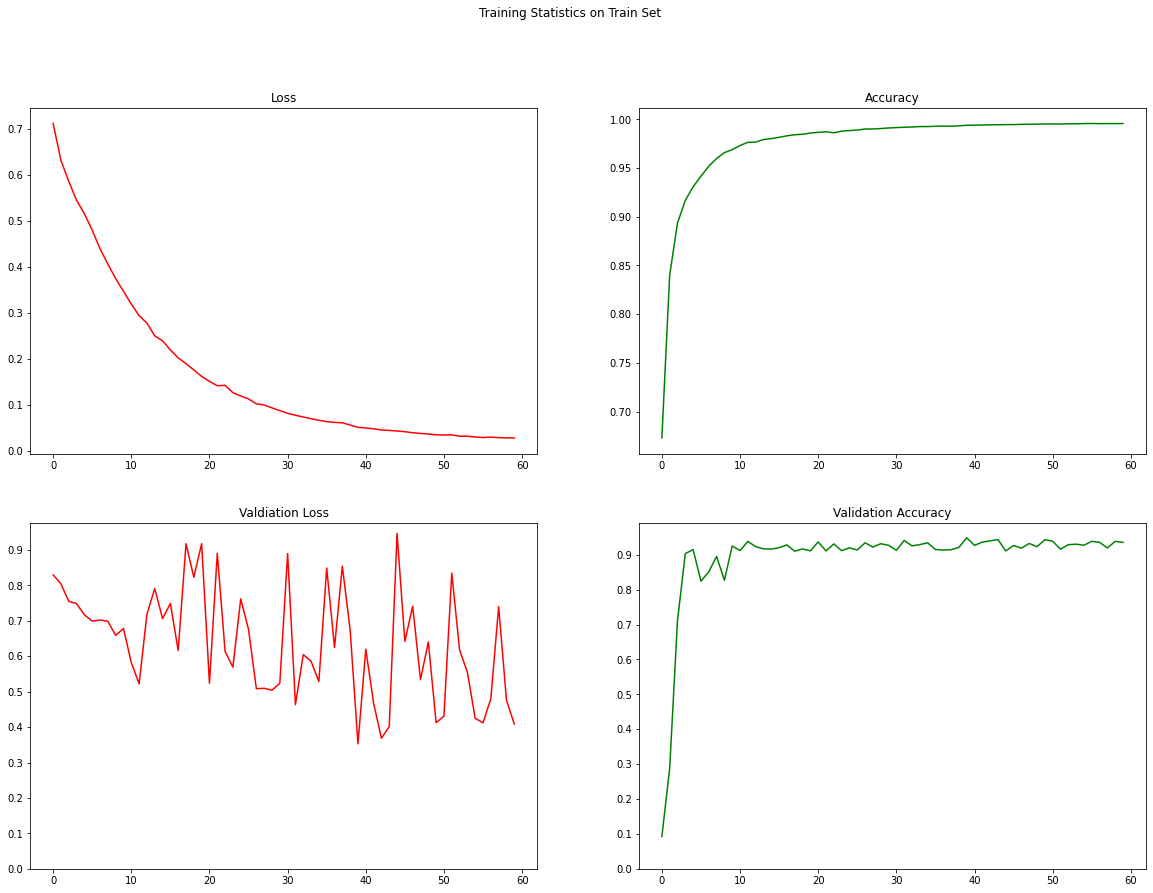

In [ ]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

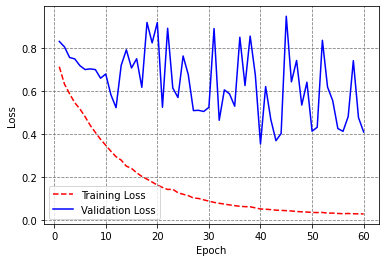

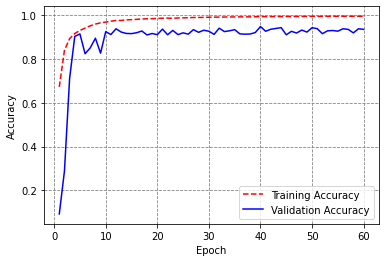

In [ ]:
# Get training and test loss histories
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']
training_acc = hist.history['accuracy']
test_acc = hist.history['val_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.grid(color='gray', linestyle='--')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Visualize accuracy history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.grid(color='gray', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Visualising Predicted Lesions

We have trained the model on the **training set**.  
We will make predictions on the unseen **test set**

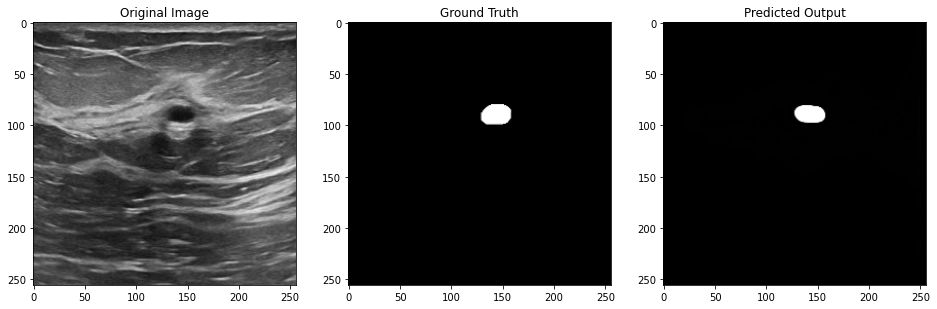

In [ ]:
img_num = 49
img_pred = model.predict(x_test[img_num].reshape(1,256,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(256, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

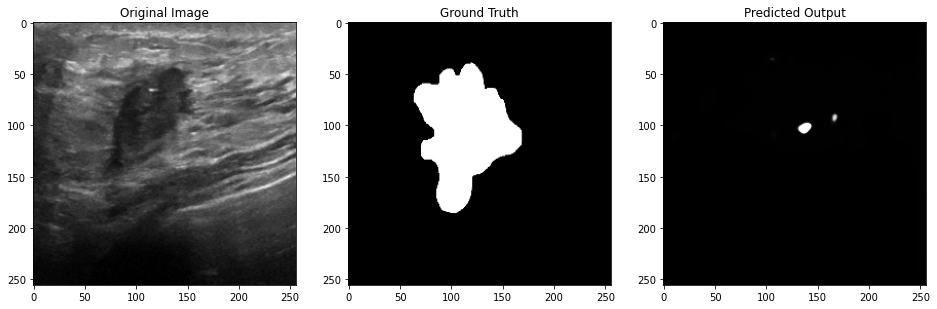

In [ ]:
img_num = 10
img_pred = model.predict(x_test[img_num].reshape(1,256,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(256, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

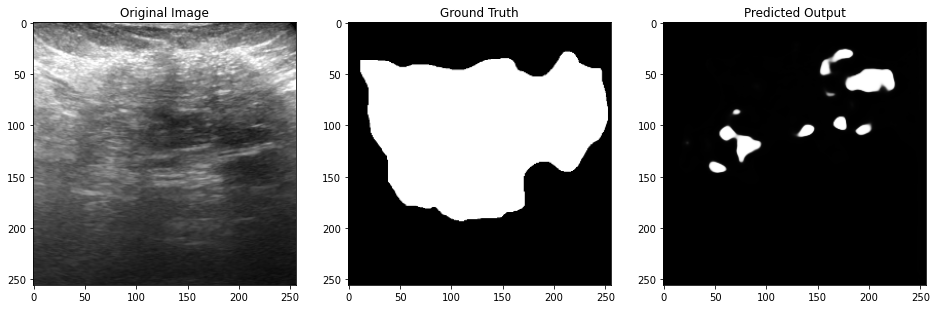

In [ ]:
img_num = 36
img_pred = model.predict(x_test[img_num].reshape(1,256,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(256, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

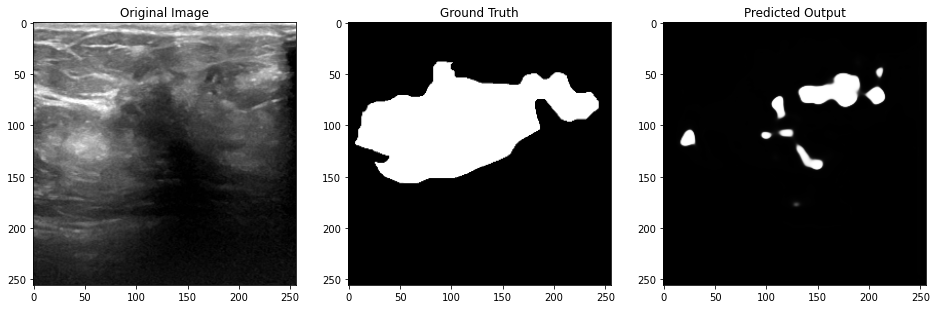

In [ ]:
img_num = 32
img_pred = model.predict(x_test[img_num].reshape(1,256,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(256, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

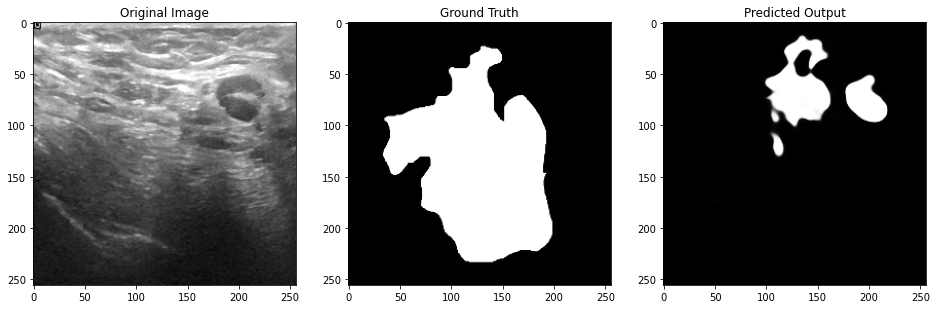

In [ ]:
img_num = 29
img_pred = model.predict(x_test[img_num].reshape(1,256,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(256, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

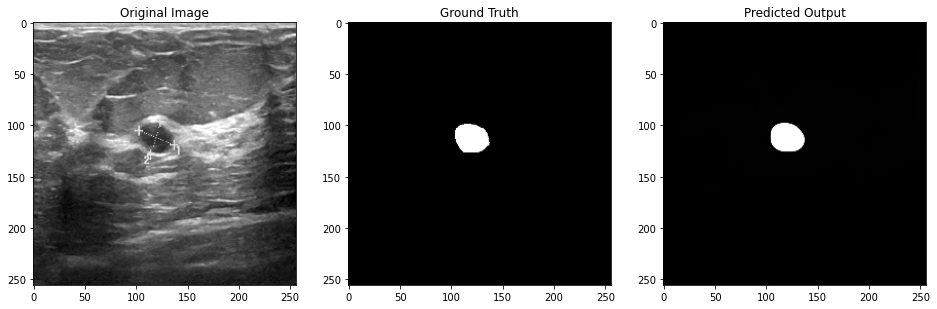

In [ ]:
img_num = 21
img_pred = model.predict(x_test[img_num].reshape(1,256,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(256, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

## Final Enhance

* Currently the predicted outputs are blurry because the predicted pixel values are in the range 0 - 1.  
* To make clear edge preditions we can enhance our image by rounding up the pixel values to 1 which are > 0.5  .
* While rounding down the pixel values to 0 which are < 0.5.
* We can enhance the image to look for absolute shape predicted by ceiling and flooring the predicted values.

In [ ]:
def enhance(img):
    sub = (model.predict(img.reshape(1,256,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub



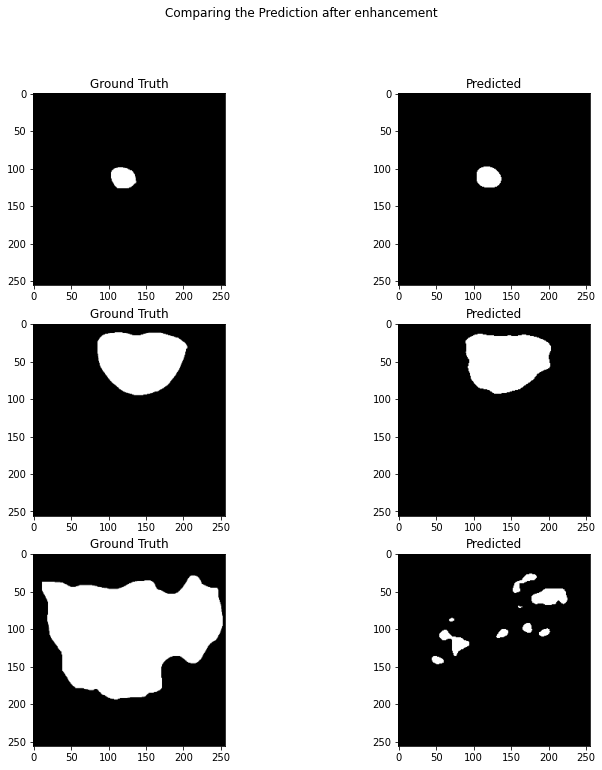

In [ ]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(256,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()